## Q-learning

This notebook will guide you through implementation of vanilla Q-learning algorithm.

You need to implement QLearningAgent (follow instructions for each method) and use it on a number of tests below.

In [1]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
        
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
pipo = defaultdict(lambda: defaultdict(lambda: 0))
print(pipo[0])

defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fc108368840>, {})


In [3]:
%%writefile qlearning.py
from collections import defaultdict
import random, math
import numpy as np

class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on http://inst.eecs.berkeley.edu/~cs188/sp09/pacman.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value

        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self,state, action,value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        #<YOUR CODE HERE> PWE
        value = -1e10
        for action in possible_actions:
            qvalue = self.get_qvalue(state, action)
            if (qvalue > value):
                value = qvalue

        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        #agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        #<YOUR CODE HERE> PWE
        q_hat = reward + gamma * self.get_value(next_state)
        q_new = learning_rate * q_hat + (1 - learning_rate) * self.get_qvalue(state, action)
        self.set_qvalue(state, action, q_new)

    
    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #<YOUR CODE HERE> PWE
        best_action = None
        best_qvalue = -1e10
        for action in possible_actions:
            qvalue = self.get_qvalue(state, action)
            if (qvalue > best_qvalue):
                best_qvalue = qvalue
                best_action = action

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.getPolicy).
        
        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #agent parameters:
        epsilon = self.epsilon

        #<YOUR CODE HERE> PWE
        if (np.random.rand() > epsilon):
            chosen_action = self.get_best_action(state)
        else:
            chosen_action = np.random.choice(possible_actions)
            
        return chosen_action

Overwriting qlearning.py


In [4]:
print(np.random.rand())

0.5781624961529328


### Try it on taxi

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [5]:
import gym
env = gym.make("Taxi-v2")

n_actions = env.action_space.n
n_states = env.observation_space.n

print(n_actions)
print(n_states)

6
500


In [6]:
from qlearning import QLearningAgent

agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

In [7]:
print(agent.get_value(10))

0


In [8]:
print(agent.alpha)
print(agent.discount)
print(agent.epsilon)
print(agent._qvalues)
print(agent.get_legal_actions(1))
print(agent.get_qvalue(300, 9))

0.5
0.99
0.25
defaultdict(<function QLearningAgent.__init__.<locals>.<lambda> at 0x7fc0cd18b1e0>, {10: defaultdict(<function QLearningAgent.__init__.<locals>.<lambda>.<locals>.<lambda> at 0x7fc0def440d0>, {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0})})
range(0, 6)
0


In [9]:
possible_actions = agent.get_legal_actions(1)
print(possible_actions)
for _ in range(10):
    print(np.random.choice(possible_actions))

range(0, 6)
4
4
2
3
5
4
3
1
2
1


In [10]:
s = env.reset()
print(s)

61


In [11]:
def play_and_train(env, agent, t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s) # <YOUR CODE>
        
        next_s, r, done, _ = env.step(a)
        
        # train (update) agent for state s
        #<YOUR CODE HERE>
        agent.update(s, a, r, next_s)
        
        s = next_s
        total_reward +=r
        if done: break
        
    return total_reward
    

eps = 2.9191091959171894e-05 mean reward = 9.0


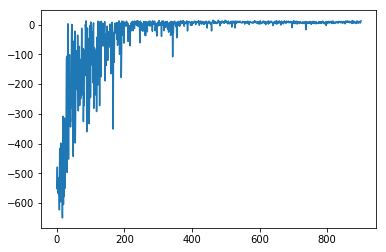

In [12]:
from IPython.display import clear_output

rewards1 = []
for i in range(1000):
    rewards1.append(play_and_train(env, agent))
    agent.epsilon *= 0.99
    
    if i %100 ==0:
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards1[-10:]))
        plt.plot(rewards1)
        plt.show()
        

### Submit to Coursera I

In [67]:
from submit import submit_qlearning1
submit_qlearning1(rewards, 'philippe.weingertner@laposte.net', 'SP4JG0JA5dx7TUH4')

Your submission doesn't reference all parts of the assignment. Please make sure you have included references to all parts within your submission. Try downloading the latest starter files if the issue still persists.


# Binarized state spaces

Use agent to train efficiently on CartPole-v0.
This environment has a continuous set of possible states, so you will have to group them into bins somehow.

The simplest way is to use `round(x,n_digits)` (or numpy round) to round real number to a given amount of digits.

The tricky part is to get the n_digits right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

In [13]:
print(round(100.332678904356, 2))

100.33


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
first state:[-0.02064204 -0.01398314 -0.02949225  0.0344304 ]


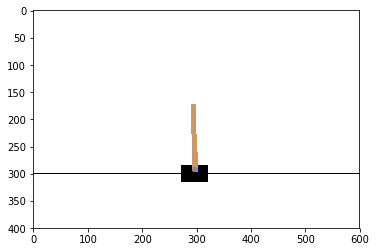

In [14]:
env = gym.make("CartPole-v0")
n_actions = env.action_space.n

print("first state:%s" % (env.reset()))
plt.imshow(env.render('rgb_array'))

In [15]:
print(n_actions)
s = env.reset()
print(s)
print(len(s))
for i in range(len(s)):
    s[i] = round(s[i], 4)
print(s)

2
[-0.01186411  0.01828821 -0.03517148 -0.00796389]
4
[-0.0119  0.0183 -0.0352 -0.008 ]


### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

(23207, 4)
-1.09028978776 2.17726949255
-1.0903 2.1773
0.00032676
-2.40512175465 2.55381457274
-2.4051 2.5538
0.00049589
-0.257235847838 0.262701185322
-0.2572 0.2627
5.199e-05
-3.13447934132 3.12832414181
-3.1345 3.1283
0.00062628


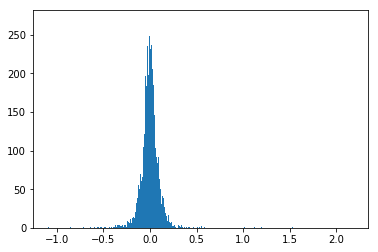

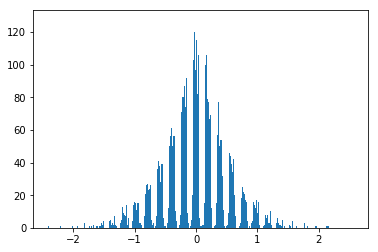

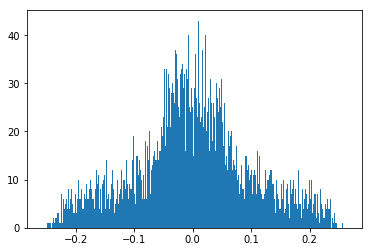

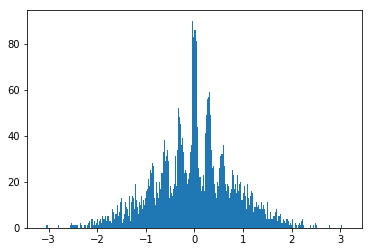

In [16]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done: break
            
all_states = np.array(all_states)
print(all_states.shape)
n_digits = 5
for i in range(all_states.shape[1]):
    x = all_states[:, i]
    print(np.min(x), np.max(x))
    mini = round(np.min(x), 4)
    maxi = round(np.max(x), 4)
    print(mini, maxi)
    print((maxi-mini)/1e4)

for obs_i in range(env.observation_space.shape[0]):
    #plt.plot(all_states[:, obs_i])
    plt.hist(all_states[:, obs_i], bins=2000)
    plt.show()

## Binarize environment

In [58]:
from gym.core import ObservationWrapper
class Binarizer(ObservationWrapper):
    
    def _observation(self, state):    
        
        #state = <round state to some amount digits.>
        #hint: you can do that with round(x,n_digits)
        #you will need to pick a different n_digits for each dimension
        
        # cf https://github.com/openai/gym/wiki/CartPole-v0
        # just using angle information i.e. state[2]
        state[0] = np.round(state[0], 0)
        state[1] = np.round(state[1], 0)
        state[2] = np.round(state[2], 2)
        state[3] = np.round(state[3], 0)

        return tuple(state)

In [59]:
env = Binarizer(gym.make("CartPole-v0"))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


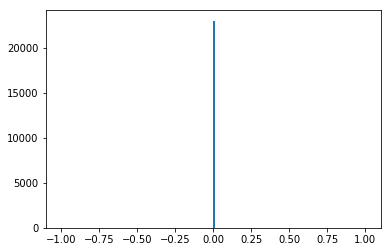

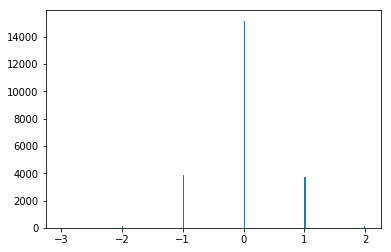

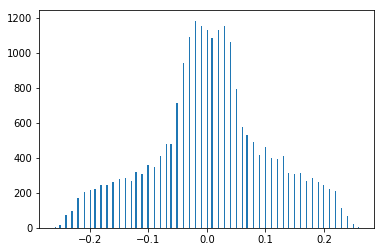

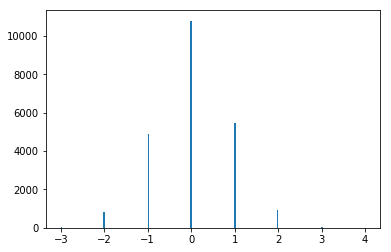

In [60]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done: break
            
all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    
    plt.hist(all_states[:,obs_i],bins=200)
    plt.show()

## Learn binarized policy

Now let's train a policy that uses binarized state space.

__Tips:__ 
* If your binarization is too coarse, your agent may fail to find optimal policy. In that case, change binarization. 
* If your binarization is too fine-grained, your agent will take much longer than 1000 steps to converge. You can either increase number of iterations and decrease epsilon decay or change binarization.
* Having 10^3 ~ 10^4 distinct states is recommended (`len(QLearningAgent._qvalues)`), but not required.


In [61]:
agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99, get_legal_actions = lambda s: range(n_actions))

In [62]:
#agent.epsilon = 0.15
print(agent.epsilon)

0.25


eps = 0.25 mean reward = 110.3


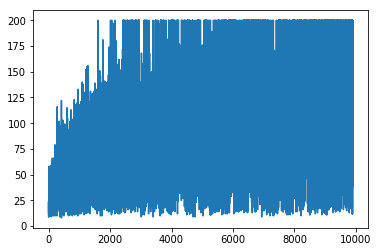

In [63]:
rewards = []
for i in range(10000):
    rewards.append(play_and_train(env,agent))   
    
    #OPTIONAL YOUR CODE: adjust epsilon
    if i %100 ==0:
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()
    
    #agent.epsilon *= 0.99
        

In [64]:
 (len(agent._qvalues))

3105

### Submit to Coursera II

In [70]:
from submit import submit_qlearning2
submit_qlearning2(rewards, rewards1, 'philippe.weingertner@laposte.net', 'SP4JG0JA5dx7TUH4')

Submitted to Coursera platform. See results on assignment page!
